# Explain your DAI Model with Decision Tree Surrogate Models

In [16]:
#H2O Python API with specific classes
import h2o                                        
from h2o.estimators.random_forest import H2ORandomForestEstimator #For single tree
from h2o.backend import H2OLocalServer                            #For plotting local tree in-notebook

import pandas as pd

#System packages for calling external graphviz processes
import os
import re
import subprocess

#In-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

from h2oai_client import Client, ModelParameters, InterpretParameters
from sklearn.model_selection import train_test_split

# Download, explore, and prepare UCI credit card default data
UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables:

* LIMIT_BAL: Amount of given credit (NT dollar)
* SEX: 1 = male; 2 = female
* EDUCATION: 1 = graduate school; 2 = university; 3 = high school; 4 = others
* MARRIAGE: 1 = married; 2 = single; 3 = others
* AGE: Age in years
* PAY_0, PAY_2 - PAY_6: History of past payment; PAY_0 = the repayment status in September, 2005; PAY_2 = the repayment status in August, 2005; ...; PAY_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
* BILL_AMT1 - BILL_AMT6: Amount of bill statement (NT dollar). BILL_AMNT1 = amount of bill statement in September, 2005; BILL_AMT2 = amount of bill statement in August, 2005; ...; BILL_AMT6 = amount of bill statement in April, 2005.
* PAY_AMT1 - PAY_AMT6: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September, 2005; PAY_AMT2 = amount paid in August, 2005; ...; PAY_AMT6 = amount paid in April, 2005.

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

# Import data and clean
The credit card default data is available as an .xls file. Pandas reads .xls files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: DEFAULT_NEXT_MONTH.

In [17]:
#Import XLS file
path = 'data/default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

#Remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

# Helper function for recoding values in the UCI credit card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset. 

In [18]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        Pandas DataFrame with recoded values.
        
    """
    
    #Define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    #Recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return frame

data = recode_cc_data(data)

# Display descriptive statistics for numeric variables

In [19]:
data.describe()

,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


# Write train and test sets from client to DAI server disk for later use

In [20]:
train_path = "data/credit_train.csv"
test_path ="data/credit_test.csv"
if not (os.path.isfile(train_path) and os.path.isfile(test_path)):
    train_pd, test_pd = train_test_split(data, test_size=0.3) #Split credticard dataset into train/test
    train_pd.to_csv(path_or_buf="data/credit_train.csv", index=False) #Write train set to csv
    test_pd.to_csv(path_or_buf="data/credit_test.csv", index=False) #Write test set to csv
else:
    traid_pd = pd.read_csv("data/credit_train.csv")
    test_pd = pd.read_csv("data/credit_test.csv")

# Connect to DAI Server

In [21]:
ip = 'localhost'
username = 'username'
password = 'password'
h2oai = Client(address = 'http://' + ip + ':12345', username = username, password = password)

# Upload data to DAI Server

In [22]:
cwd = os.getcwd()
train_path_dai = cwd+"/data/credit_train.csv" #DAI needs absolute path
test_path_dai = cwd+"/data/credit_test.csv"  #DAI needs absolute path
train = h2oai.create_dataset_sync(train_path_dai)
test = h2oai.create_dataset_sync(test_path_dai)

# Setup parameters for DAI experiment

In [23]:
#Set the parameters you want to pass to DAI 
#These are the same parameters you see in the DAI GUI
dataset_key=train.key #Dataset to use for DAI
validset_key='' #Validation set to use for DAI (Note, we are not using one for this experiment 
                #as DAI will make and use an internal validation set)
testset_key=test.key #Test set to use for DAI
target="DEFAULT_NEXT_MONTH" #Target column for DAI
dropped_cols=['ID'] #List of columns to drop. In this case we are dropping 'ID'
weight_col=None #The column that indicates the per row observation weights. 
                #If None, each row will have an observation weight of 1
fold_col=None #The column that indicates the fold. If None, the folds will be determined by DAI
time_col='[OFF]' #Time Column: The column that provides a time order, if applicable.
                  #if [AUTO], Driverless AI will auto-detect a potential time order
                  #if [OFF], auto-detection is disabled
is_time_series=False #Whether or not the experiment is a time series problem
classification=True #Inform DAI if the problem type is a classification (binomial/multinomial) 
                    #or not (regression)
enable_gpus=True #Whether or not to enable GPUs
seed=1234 #Use seed for reproducibility
scorer_str='auc' #Set evaluation metric. In this case we are interested in optimizing AUC
accuracy=5 #Accuracy setting for experiment (One of the 3 knobs you see in the DAI UI)
time=5 #Time setting for experiment (One of the 3 knobs you see in the DAI UI)
interpretability=5 #Interpretability setting for experiment (One of the 3 knobs you see in the DAI UI)
config_overrides=None #Extra parameters that can be passed in TOML format

For information on the experiment settings, refer to the [Experiment Settings](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/launching.html#experimentsettings).

# Preview DAI experiment
For this example, we will be predicting default payment next month. The parameters that control the experiment process are:  accuracy, time, and interpretability. We can use the get_experiment_preview_sync function to get a sense of what will happen during the experiment.

We will start out by seeing what the experiment will look like with accuracy, time, and interpretability all set to 5.

In [24]:
exp_preview = h2oai.get_experiment_preview_sync(dataset_key=train.key, 
                                                validset_key=validset_key, 
                                                classification=classification, 
                                                dropped_cols=dropped_cols, 
                                                target_col=target, 
                                                time_col=time_col, 
                                                enable_gpus=enable_gpus, 
                                                accuracy=accuracy, 
                                                time=time, 
                                                interpretability=interpretability, 
                                                config_overrides=config_overrides)
exp_preview

['ACCURACY [5/10]:',
 '- Training data size: *21,000 rows, 24 cols*',
 '- Feature evolution: *XGBoost*, *1/3 validation split*',
 '- Final pipeline: *Ensemble (1xXGBoost), 4-fold CV*',
 '',
 'TIME [5/10]:',
 '- Feature evolution: *4 individuals*, up to *58 iterations*',
 '- Early stopping: After *10* iterations of no improvement',
 '',
 'INTERPRETABILITY [5/10]:',
 '- Feature pre-pruning strategy: None',
 '- Monotonicity constraints: disabled',
 '- Feature engineering search space (where applicable): [Clustering, Date, FrequencyEncoding, Identity, Interactions, NumEncoding, TargetEncoding, Text, TruncatedSVD, WeightOfEvidence]',
 '',
 'XGBoost models to train:',
 '- Model and feature tuning: *16*',
 '- Feature evolution: *104*',
 '- Final pipeline: *4*',
 '',
 'Estimated max. total memory usage:',
 '- Feature engineering: *224.0MB*',
 '- GPU XGBoost: *24.0MB*',
 '',
 'Estimated runtime: *8 minutes*']

With these settings, the Driverless AI experiment should take around 5 minutes to run and will train about 119 models:

* 16 for model and feature tuning
* 102 for feature evolution
* 1 for the final pipeline

Driverless AI can suggest the parameters based on the dataset and target column. Below we will use the get_experiment_tuning_suggestion to see what settings Driverless AI suggests.

In [25]:
#Let Driverless suggest parameters for experiment
params = h2oai.get_experiment_tuning_suggestion(dataset_key=train.key, 
                                                target_col=target, 
                                                is_time_series=is_time_series,
                                                is_classification=classification,
                                                config_overrides=config_overrides)
params.dump()

{'dataset_key': 'sakolete',
 'target_col': 'DEFAULT_NEXT_MONTH',
 'weight_col': '',
 'fold_col': '',
 'orig_time_col': '',
 'time_col': '',
 'is_classification': True,
 'cols_to_drop': [],
 'validset_key': '',
 'testset_key': '',
 'enable_gpus': True,
 'seed': False,
 'accuracy': 6,
 'time': 3,
 'interpretability': 6,
 'scorer': 'AUC',
 'time_groups_columns': [],
 'time_period_in_seconds': None,
 'num_prediction_periods': None,
 'num_gap_periods': None,
 'is_timeseries': False,
 'config_overrides': None}

Driverless AI has found that the best parameters are to set accuracy = 6, time = 3, and interpretability = 6. It has selected AUC as the scorer (this is the default scorer for binomial problems).

We can see our experiment preview with the suggested settings below.

In [26]:
exp_preview = h2oai.get_experiment_preview_sync(dataset_key=dataset_key, 
                                                validset_key=validset_key, 
                                                classification=classification, 
                                                dropped_cols =dropped_cols, 
                                                target_col=target, 
                                                time_col=time_col, 
                                                enable_gpus=enable_gpus, 
                                                accuracy=params.accuracy, #DAI suggested 
                                                                            #for accuracy 
                                                time=params.time, #DAI suggested 
                                                                    #for time
                                                interpretability=params.interpretability, #DAI 
                                                                #suggested for interpretability
                                                config_overrides=config_overrides)
exp_preview

['ACCURACY [6/10]:',
 '- Training data size: *21,000 rows, 24 cols*',
 '- Feature evolution: *XGBoost*, *1/3 validation split*',
 '- Final pipeline: *Ensemble (1xGLM, 1xXGBoost), 5-fold CV*',
 '',
 'TIME [3/10]:',
 '- Feature evolution: *4 individuals*, up to *42 iterations*',
 '- Early stopping: After *5* iterations of no improvement',
 '',
 'INTERPRETABILITY [6/10]:',
 '- Feature pre-pruning strategy: FS',
 '- Monotonicity constraints: disabled',
 '- Feature engineering search space (where applicable): [Date, FrequencyEncoding, Identity, Interactions, NumEncoding, TargetEncoding, Text, WeightOfEvidence]',
 '',
 'XGBoost models to train:',
 '- Model and feature tuning: *24*',
 '- Feature evolution: *64*',
 '- Final pipeline: *10*',
 '',
 'Estimated max. total memory usage:',
 '- Feature engineering: *224.0MB*',
 '- GPU XGBoost: *24.0MB*',
 '',
 'Estimated runtime: *3 minutes*']

# Launch experiment
Launch the experiment using the accuracy, time, and interpretability settings DAI suggested

In [27]:
experiment = h2oai.start_experiment_sync(
    
    #Datasets
    dataset_key=train.key, 
    validset_key=validset_key,
    testset_key=testset_key, 
    
    #Columns
    target_col=target,
    cols_to_drop=dropped_cols,
    weight_col=weight_col,
    fold_col=fold_col,
    orig_time_col=time_col,
    time_col=time_col,
    
    #Parameters
    is_classification=classification,
    enable_gpus=enable_gpus,
    seed=seed,
    accuracy=params.accuracy, #DAI suggested for accuracy
    time=params.time, #DAI suggested for time
    interpretability=params.interpretability, #DAI suggested for interpretability
    scorer=scorer_str,
    is_timeseries=is_time_series
)

# View the final model score for the validation and test datasets
When feature engineering is complete, an ensemble model can be built depending on the accuracy setting. The experiment object also contains the score on the validation and test data for this ensemble model. In this case, the validation score is the score on the training cross-validation predictions.

In [28]:
print("Final Model Score on Validation Data: " + str(round(experiment.valid_score, 3)))
print("Final Model Score on Test Data: " + str(round(experiment.test_score, 3)))

Final Model Score on Validation Data: 0.783
Final Model Score on Test Data: 0.779


# Variable importance for DAI experiment
The tables outputted below shows the feature name, its relative importance, and a description. 

For the transformed variable importance table some features will be engineered by Driverless AI and some can be the original feature.

In [67]:
%%capture
#Download Summary
import subprocess
summary_path=h2oai.download(src_path=experiment.summary_path, dest_dir=".")
dir_path="./h2oai_experiment_summary_" + experiment.key
subprocess.call(['unzip', '-o', summary_path, '-d', dir_path], shell=False)

#### Variable importance for transformed features

In [68]:
#View Features
features = pd.read_table(dir_path + "/features.txt", sep=',', skipinitialspace=True)
features.head(n=30)

,Relative Importance,Feature,Description
0,1.00000,2_CVTE:PAY_0.0,Out-of-fold mean of the response grouped by: [...
1,0.46926,3_CVTE:PAY_2.0,Out-of-fold mean of the response grouped by: [...
2,0.27989,4_CVTE:PAY_3.0,Out-of-fold mean of the response grouped by: [...
3,0.21098,22_PAY_AMT6,PAY_AMT6 (original)
4,0.20207,10_BILL_AMT1,BILL_AMT1 (original)
5,0.20133,16_LIMIT_BAL,LIMIT_BAL (original)
6,0.18217,21_PAY_AMT5,PAY_AMT5 (original)
7,0.18015,18_PAY_AMT2,PAY_AMT2 (original)
8,0.17851,19_PAY_AMT3,PAY_AMT3 (original)
9,0.17621,5_CVTE:PAY_4.0,Out-of-fold mean of the response grouped by: [...


#### Variable importance for original features 

In [69]:
#View Features
features = pd.read_table(dir_path + "/features_orig.txt", sep=',', skipinitialspace=True)
features.head(n=30)

,Relative Importance,Original Feature
0,0.205610,PAY_0
1,0.096484,PAY_2
2,0.057547,PAY_3
3,0.043378,PAY_AMT6
4,0.041548,BILL_AMT1
5,0.041394,LIMIT_BAL
6,0.037455,PAY_AMT5
7,0.037040,PAY_AMT2
8,0.036704,PAY_AMT3
9,0.036230,PAY_4


# Setup scoring package from DAI experiment

In [30]:
h2oai.download(experiment.scoring_pipeline_path, '.')

'./scorer.zip'

#### Execute external processes to install scoring artifact

In [31]:
%%capture
%%bash
#Unzip scoring package and install the scoring python library
unzip scorer;

In [32]:
#Import scoring module
!pip install scoring-pipeline/scoring_h2oai_experiment_*.whl

Processing ./scoring-pipeline/scoring_h2oai_experiment_kinevoba-1.0.0-py3-none-any.whl
You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


#### Import scoring package installed directly above

In [33]:
from scoring_h2oai_experiment_kinevoba import Scorer #Make sure to add experiment name to  
                                                     #import scoring_h2oai_experiment_* 

In [34]:
%%capture
#Create a singleton Scorer instance.
#For optimal performance, create a Scorer instance once, and call score() or score_batch() multiple times.
scorer = Scorer()

In [35]:
#Check colum names used for scorer()
scorer.get_column_names()

('LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6')

In [36]:
scores = scorer.score_batch(test_pd).drop('DEFAULT_NEXT_MONTH.0', axis=1)

stype.int8


In [37]:
scores = scores.rename(columns={"DEFAULT_NEXT_MONTH.1": "p_DEFAULT_NEXT_MONTH"})
assert scores.shape[0] == test_pd.shape[0], "Test set rows and score rows should match!"
scores.head()

,p_DEFAULT_NEXT_MONTH
0,0.729808
1,0.257898
2,0.727426
3,0.119459
4,0.064054


### Train decision tree surrogate model's to describe the DAI model¶
A surrogate model is a simple model that is used to explain a complex model. One of the original references for surrogate models is available here: https://papers.nips.cc/paper/1152-extracting-tree-structured-representations-of-trained-networks.pdf. In this example, a single decision tree will be trained on the original inputs and predictions of the DAI model and the tree will be visualized using special functionality in h2o and GraphViz. The variable importance, interactions, and decision paths displayed in the directed graph of the trained decision tree surrogate model are then assumed to be indicative of the internal mechanisms of the more complex DAI model, creating an approximate, overall flowchart for the DAI model. There are few mathematical guarantees that the simple surrogate model is highly representative of the more complex DAI model, but a recent preprint article has put forward ideas on strenghthening the theoretical relationship between surrogate models and more complex models: https://arxiv.org/pdf/1705.08504.pdf. Since surrogate models alone do not guarantee accurate transparency, they should be used along with DAI variable importance and other explanation techniques to build a cohesive narrative about the mechansims within the DAI model.

### Create datasets for surrogate model¶
To train a surrogate model, the predictions and original inputs of the complex model to be explained need to be in the same dataset. The test data is used here to see how the model behaves on holdout data, which should be closer to its behavior on new data than analyzing the surrogate model for the training inputs and predictions.

In addition to the above, the predictions and transformed features made from the DAI model will be put into the same dataset, as well. This will provide a means of comparison for a surrogate model on original features versus a surrogate model on transformed features. 

In [38]:
#Start H2O 
h2o.init(max_mem_size='2G')       #Start h2o
h2o.remove_all()                  #Remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,8 mins 17 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.6
H2O cluster version age:,9 days
H2O cluster name:,H2O_from_python_navdeep_vbg4ng
H2O cluster total nodes:,1
H2O cluster free memory:,1.492 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"


In [39]:
#Transform dataset to get transformed features from DAI
transformation = h2oai.fit_transform_batch_sync(model_key=experiment.key, 
                               training_input_csv_path=test_path_dai, 
                               validation_input_csv_path='',
                               test_input_csv_path='',
                               validation_split_fraction=0.75,
                               seed=1234,
                               fold_column='')

In [50]:
#Build dataset that contains transformed features and predictions from the DAI model
test_pd_transformed = pd.read_csv("../../../tmp/"+transformation.training_output_csv_path)
test_pd_transformed.reset_index(drop=True, inplace=True)
scores.reset_index(drop=True, inplace=True)
test_transformed_yhat = pd.concat([test_pd_transformed, scores], axis=1)

#Convert to h2o frame to be used in H2O DT Surrogate model
column_types = ['real'] * (test_pd_transformed.shape[1] + 1)
test_transformed_yhat = h2o.H2OFrame(test_transformed_yhat, column_types=column_types)
test_transformed_yhat.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


0_CVTE:EDUCATION.0,1_CVTE:MARRIAGE.0,2_CVTE:PAY_0.0,3_CVTE:PAY_2.0,4_CVTE:PAY_3.0,5_CVTE:PAY_4.0,6_CVTE:PAY_5.0,7_CVTE:PAY_6.0,8_CVTE:SEX.0,9_AGE,10_BILL_AMT1,11_BILL_AMT2,12_BILL_AMT3,13_BILL_AMT4,14_BILL_AMT5,15_BILL_AMT6,16_LIMIT_BAL,17_PAY_AMT1,18_PAY_AMT2,19_PAY_AMT3,20_PAY_AMT4,21_PAY_AMT5,22_PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
0.25817,0.226804,0.31982,0.197368,0.180077,0.192727,0.196429,0.171598,0.240981,42,0,0,0,0,0,7010,80000,0,0,0,0,6204,1000,0,0.729808
0.234467,0.223464,0.133482,0.174737,0.193038,0.189899,0.202381,0.192308,0.209035,27,48051,49247,48799,49508,50686,51815,100000,2000,2200,1822,2000,2100,2100,0,0.257898
0.239631,0.226804,0.141583,0.172228,0.193038,0.190525,0.194444,0.192308,0.232061,60,131550,132114,133281,123958,124474,120570,230000,6057,4845,4291,4115,4274,4054,0,0.727426
0.22807,0.227425,0.330189,0.563559,0.493617,0.478049,0.533333,0.540881,0.240981,24,25932,24924,22599,24613,23922,25481,50000,1800,0,2700,0,2100,0,0,0.119459
0.246813,0.220204,0.141583,0.169279,0.171306,0.190525,0.20649,0.192308,0.209035,32,169108,170419,142264,101952,103174,105464,290000,7118,5800,3792,4010,4276,3655,0,0.0640536
0.248535,0.223464,0.13587,0.165289,0.188525,0.161677,0.202381,0.190428,0.221034,48,53044,51158,29452,1696,38585,38884,60000,1607,1675,1696,38000,1500,1400,0,0.118313
0.1968,0.228415,0.303318,0.579399,0.50655,0.50495,0.533333,0.287092,0.217467,25,8483,10186,10871,10402,12077,11594,20000,2000,1000,0,2000,0,0,1,0.328701
0.197694,0.227425,0.141583,0.167545,0.182383,0.156442,0.194444,0.190091,0.217467,25,8046,6130,3653,32511,24814,25293,170000,1085,1000,32517,1023,10000,5000,0,0.102613
0.197694,0.223464,0.15727,0.145714,0.175978,0.166181,0.156342,0.168142,0.21624,44,29227,49177,143588,82261,44242,22999,320000,49619,143588,82691,44242,24010,128424,0,0.301304
0.234467,0.220605,0.330189,0.192,0.175978,0.153179,0.160656,0.168142,0.21624,35,0,0,554,4131,930,0,120000,0,554,4131,930,0,2581,0,0.606547


In [52]:
#Build dataset that contains original features and predictions from the DAI model
test_pd.reset_index(drop=True, inplace=True)
scores.reset_index(drop=True, inplace=True)
test_yhat = pd.concat([test_pd, scores], axis=1)

#Convert to h2o frame to be used in H2O DT Surrogate model
test_yhat = h2o.H2OFrame(test_yhat)
test_yhat.head()

Parse progress: |█████████████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
26648,40000,male,graduate school,single,26,2 month delay,use of revolving credit,use of revolving credit,2 month delay,2 month delay,use of revolving credit,36460,37549,40527,41036,39103,38945,2000,3900,1500,0,1600,1600,1,0.729808
1545,360000,female,university,single,34,1 month delay,no consumption,no consumption,pay duly,pay duly,no consumption,0,0,0,700,0,0,0,0,700,0,0,0,1,0.257898
13963,30000,female,high school,married,54,2 month delay,2 month delay,2 month delay,use of revolving credit,use of revolving credit,2 month delay,23498,26400,25682,26155,27972,27374,3600,0,1200,2400,0,2300,1,0.727426
354,80000,female,university,single,43,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,77057,78102,58501,51042,19036,19414,3177,2600,3000,1691,695,882,0,0.119459
2177,320000,male,university,single,35,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,12233,16490,20011,17918,18627,19167,7000,4100,1000,1000,1000,1000,0,0.0640536
29289,110000,male,university,single,26,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,61167,60549,55400,10711,10868,11079,2721,2422,1132,289,341,327,0,0.118313
6396,50000,male,graduate school,single,26,pay duly,pay duly,pay duly,pay duly,2 month delay,2 month delay,526,526,526,1913,1226,1752,526,526,1913,0,1052,0,1,0.328701
22014,40000,female,graduate school,single,27,pay duly,use of revolving credit,use of revolving credit,pay duly,pay duly,use of revolving credit,27025,32228,38904,4235,87230,72647,6000,8040,4235,87230,3000,10000,1,0.102613
9665,20000,male,university,single,23,use of revolving credit,use of revolving credit,2 month delay,use of revolving credit,use of revolving credit,no consumption,16831,20404,19621,14051,0,0,4183,0,281,0,0,0,1,0.301304
15824,50000,female,university,married,27,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,pay duly,use of revolving credit,50151,48945,36467,18890,30288,30003,1724,1819,2664,31057,1064,1073,0,0.606547


### Train two single H2O decision tree surrogate models: One using original features  &  another using transformed features
A single decision tree is trained on the original features and predictions in addition to another single decision tree that is trained on the transformed features and predictions. To simulate a single decision tree in h2o, the H2ORandomForestEstimator class is used, but only one tree is trained instead of a forest of decision trees. Setting the mtry parameter to -2 tells the H2ORandomForestEstimator to consider all variables in all splits of a tree, instead of considering a random subset of columns. It is also recommended to set a random seed for reproducibility and to set max_depth to a lower number, say less than 6, so that the surrogate model will not become overly complex and hard to explain and understand. Once the tree is trained, a model optimized java object (MOJO) representation of the tree is saved. H2O provides a way to visualize the trained tree in detail using the MOJO and Graphviz.

In [54]:
#Assign target and inputs for DT surrogate model
y = 'DEFAULT_NEXT_MONTH'
yhat = 'p_DEFAULT_NEXT_MONTH'
X = [name for name in test_pd.columns if name not in [y, 'ID', 'DEFAULT_NEXT_MONTH']]
print('yhat =', yhat)
print('X =', X)
print("\n")

#Assign inputs for DT surrogate model
X_transformed = [name for name in test_pd_transformed.columns if name not in [y, 'ID', 'DEFAULT_NEXT_MONTH']]
print('yhat =', yhat)
print('X =', X_transformed)

yhat = p_DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


yhat = p_DEFAULT_NEXT_MONTH
X = ['0_CVTE:EDUCATION.0', '1_CVTE:MARRIAGE.0', '2_CVTE:PAY_0.0', '3_CVTE:PAY_2.0', '4_CVTE:PAY_3.0', '5_CVTE:PAY_4.0', '6_CVTE:PAY_5.0', '7_CVTE:PAY_6.0', '8_CVTE:SEX.0', '9_AGE', '10_BILL_AMT1', '11_BILL_AMT2', '12_BILL_AMT3', '13_BILL_AMT4', '14_BILL_AMT5', '15_BILL_AMT6', '16_LIMIT_BAL', '17_PAY_AMT1', '18_PAY_AMT2', '19_PAY_AMT3', '20_PAY_AMT4', '21_PAY_AMT5', '22_PAY_AMT6']


In [55]:
model_id = 'dt_surrogate_mojo' #Gives MOJO artifact a recognizable name

#Initialize single tree surrogate model
surrogate = H2ORandomForestEstimator(ntrees=1,          #Use only one tree
                                     sample_rate=1,     #Use all rows in that tree
                                     mtries=-2,         #Use all columns in that tree
                                     max_depth=3,       #Shallow trees are easier to understand
                                     seed=12345,        #Random seed for reproducibility
                                     model_id=model_id) #Gives MOJO artifact a recognizable name

#Train single tree surrogate model
surrogate.train(x=X, y=yhat, training_frame=test_yhat)

#Persist MOJO (compiled, representation of trained model)
#From which to generate plot of surrogate
mojo_path = surrogate.download_mojo(path='.')
print('Generated MOJO path:\n', mojo_path)

#Transformed features
model_id_transformed = 'dt_surrogate_transformed_mojo' #Gives MOJO artifact a recognizable name

#Initialize single tree surrogate model for transformed features frame
surrogate_transformed = H2ORandomForestEstimator(ntrees=1,          #Use only one tree
                                     sample_rate=1,     #Use all rows in that tree
                                     mtries=-2,         #Use all columns in that tree
                                     max_depth=3,       #Shallow trees are easier to understand
                                     seed=12345,        #Random seed for reproducibility
                                     model_id=model_id_transformed) #Gives MOJO artifact a recognizable name

#Train single tree surrogate model
surrogate_transformed.train(x=X_transformed, y=yhat, training_frame=test_transformed_yhat)

#Persist MOJO (compiled, representation of trained model)
#From which to generate plot of surrogate
mojo_path_transformed = surrogate_transformed.download_mojo(path='.')
print('Generated MOJO path for transformed feature dataset:\n', mojo_path_transformed)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/navdeep/h2oai/examples/h2oai_client_demo/mli/dt_surrogate_mojo.zip
drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path for transformed feature dataset:
 /home/navdeep/h2oai/examples/h2oai_client_demo/mli/dt_surrogate_transformed_mojo.zip


### Create GraphViz dot file for original features and transformed features
GraphViz is an open source graph visualization tool. It is freely available from this url: http://www.graphviz.org/. To plot the trained decision tree surrogate model, a special h2o class, PrintMojo, is executed against the MOJO to create a GraphViz dot file representation of the tree.

In [56]:
#Original Features

#Title for plot
title = 'Credit Card Default Decision Tree Surrogate for Original Features'  

#Locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

#Construct command line call to generate graphviz version of 
#Surrogate tree see for more information: 
#http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name = model_id + '.gv'
gv_args = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path + ' -o').split()
gv_args.insert(0, 'java')
gv_args.append(gv_file_name)
if title is not None:
    gv_args = gv_args + ['--title', title]
    
#Call 
print()
print('Calling external process ...')
print(' '.join(gv_args))
_ = subprocess.call(gv_args)

Discovered H2O jar path:
 /home/navdeep/h2oai/env/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/navdeep/h2oai/env/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/navdeep/h2oai/examples/h2oai_client_demo/mli/dt_surrogate_mojo.zip -o dt_surrogate_mojo.gv --title Credit Card Default Decision Tree Surrogate for Original Features


In [57]:
#Transformed Features

#Title for plot
title = 'Credit Card Default Decision Tree Surrogate for Transformed Features'  

#Locate h2o jar
hs = H2OLocalServer()
h2o_jar_path = hs._find_jar()
print('Discovered H2O jar path:\n', h2o_jar_path)

#Construct command line call to generate graphviz version of 
#Surrogate tree see for more information: 
#http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
gv_file_name_transformed = model_id_transformed + '.gv'
gv_args_transformed = str('-cp ' + h2o_jar_path +
              ' hex.genmodel.tools.PrintMojo --tree 0 -i '
              + mojo_path_transformed + ' -o').split()
gv_args_transformed.insert(0, 'java')
gv_args_transformed.append(gv_file_name_transformed)
if title is not None:
    gv_args_transformed = gv_args_transformed + ['--title', title]
    
#Call 
print()
print('Calling external process ...')
print(' '.join(gv_args_transformed))
_ = subprocess.call(gv_args_transformed)

Discovered H2O jar path:
 /home/navdeep/h2oai/env/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/navdeep/h2oai/env/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/navdeep/h2oai/examples/h2oai_client_demo/mli/dt_surrogate_transformed_mojo.zip -o dt_surrogate_transformed_mojo.gv --title Credit Card Default Decision Tree Surrogate for Transformed Features


### Create PNG from GraphViz dot file and display for original features
Then a GraphViz command line tool is used to create a static PNG image from the dot file ...

In [58]:
#Construct call to generate PNG from 
#graphviz representation of the tree
png_file_name = model_id + '.png'
png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
png_args = png_args.split()

#Call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_mojo.gv -o dt_surrogate_mojo.png


### Display surrogate decision tree in notebook
... and the image is displayed in the notebook.

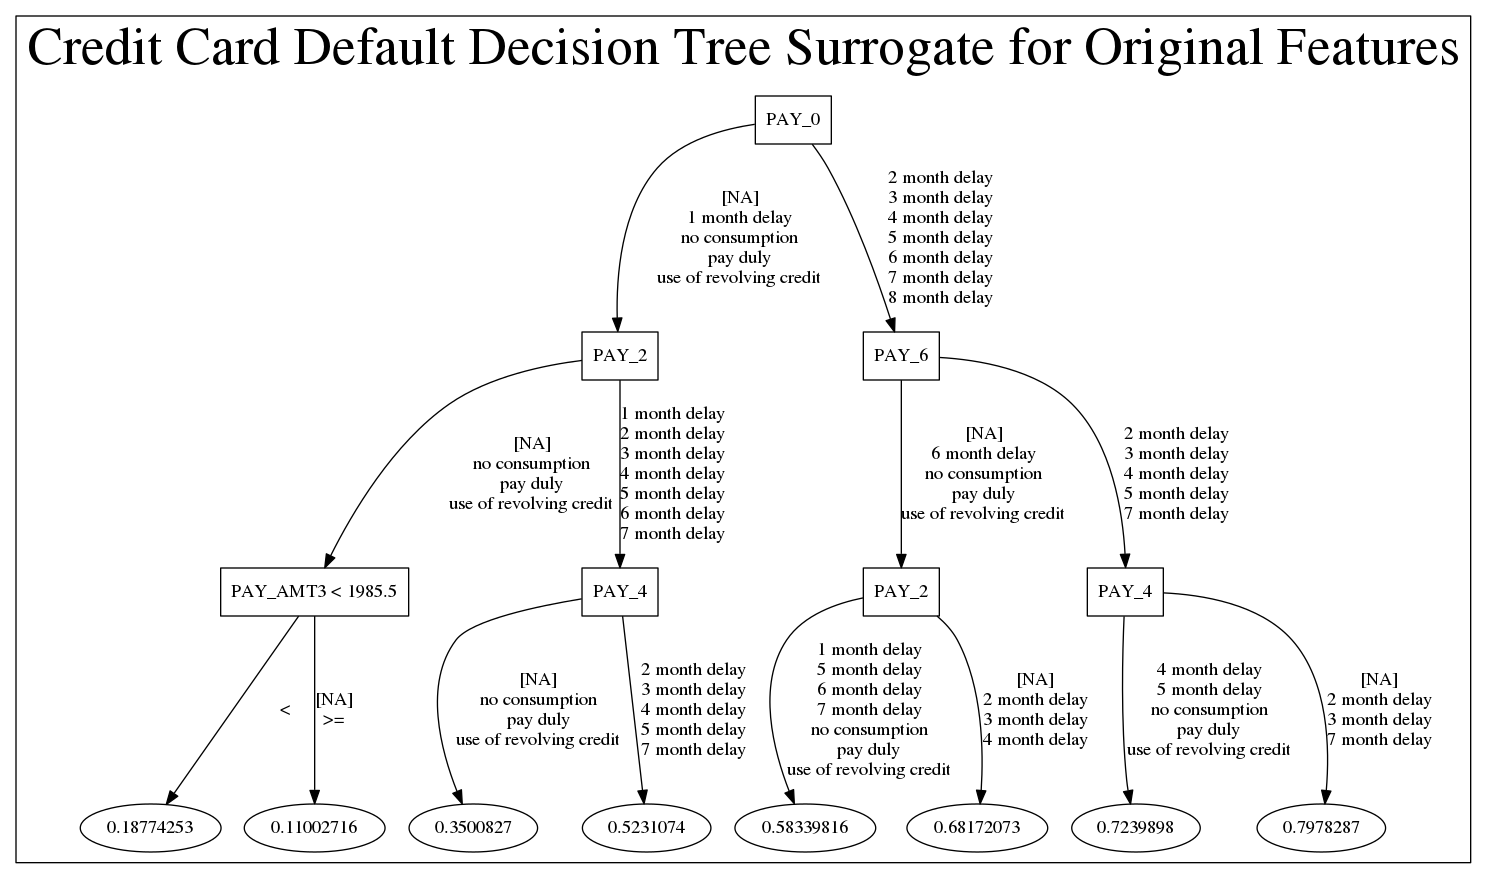

In [59]:
#Display in-notebook# displa 
display(Image((png_file_name)))

### Analyze surrogate model and compare to global DAI variable importance
The displayed tree is comparable with the global DAI variable importance for original features. A simple heuristic rule for variable importance in a decision tree relates to the depth and frequency at which a variable is split on in a tree: variables used higher in the tree and more frequently in the tree are more important. Most of the variables pictured in this tree also appear as highly important in the DAI variable importance plot for original features. In both cases, PAY_0 is appearing as crucially important (PAY_0 is used as a feature transform for the most import variable in DAI), with other payment behavior variables following close behind. The surrogate decision tree enables users to understand and confirm not only what input variables are important, but also how their values contribute to model decisions. For instance, to fall into the lowest probability of default leaf node in the surrogate decision tree a customer must make their first and second payments in a timely fashion and then pay greater than or equal to 1985.5 New Tiawanese Dollars for their third payment. Conversely, customers who miss their first, sixth, and fourth payments fall into the highest probability of default leaf node of the surrogate decision tree. It is also imperative to compare these results to domain knowledge and reasonable expectations. In this case, the global explanatory methods applied thus far tell a consisent and reasonable story about the DAI model's behavior. If this was not so, steps should be taken to either reconcile or remove inconsistencies and unreasonable prediction behavior.

### Create PNG from GraphViz dot file and display for transformed features
Then a GraphViz command line tool is used to create a static PNG image from the dot file ...

In [60]:
#Construct call to generate PNG from 
#graphviz representation of the tree
png_file_name = model_id_transformed + '.png'
png_args = str('dot -Tpng ' + gv_file_name_transformed + ' -o ' + png_file_name)
png_args = png_args.split()

#Call
print('Calling external process ...')
print(' '.join(png_args))
_ = subprocess.call(png_args)

Calling external process ...
dot -Tpng dt_surrogate_transformed_mojo.gv -o dt_surrogate_transformed_mojo.png


### Display surrogate decision tree in notebook
... and the image is displayed in the notebook.

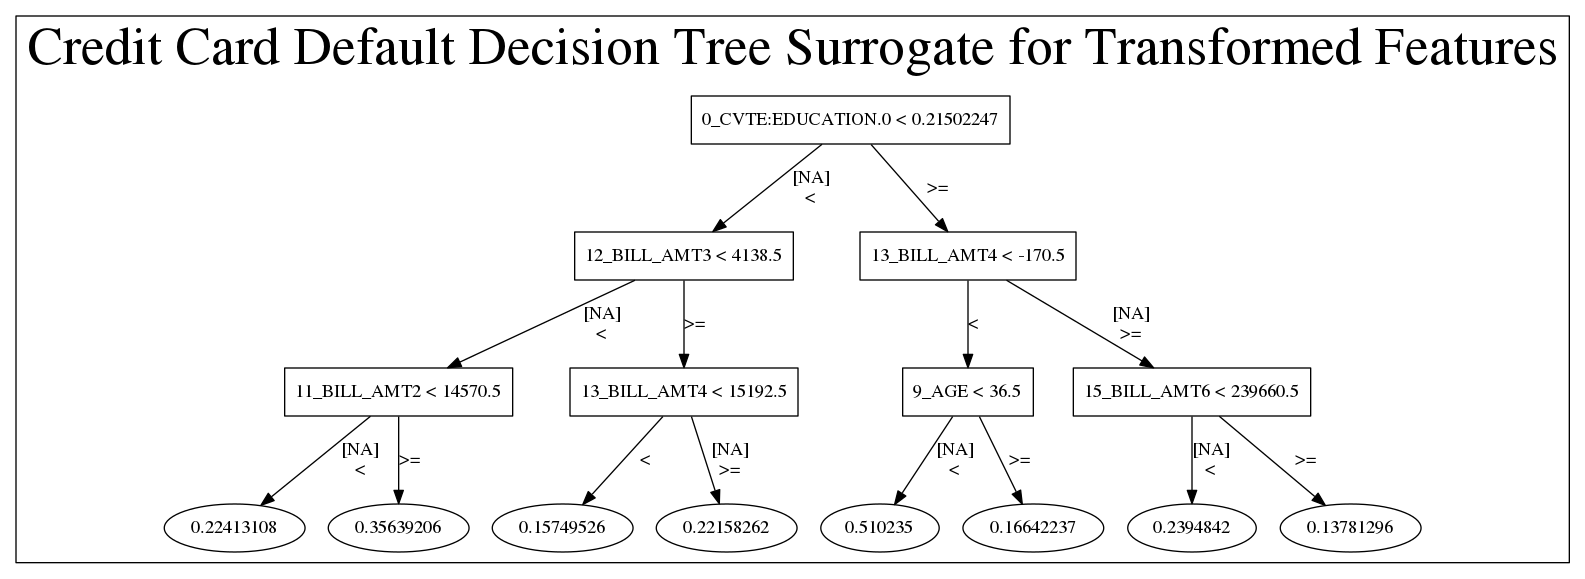

In [61]:
#Display in-notebook# displa 
display(Image((png_file_name)))

# Summary
In this notebook, a DAI model was trained to predict credit card defaults and explained at a global scale with a decision tree surrogate model. The decision tree surrogate creates an overall approximate flowchart for the DAI model's decision processes. Decision tree surrogate models enhance the transparency of the complex DAI model, which in turn enables greater accountability for the model's predictions. This technique should generalize well for many types of business and research problems, enabling you to train a complex DAI model and explain it to your colleagues, bosses, and potentially, external regulators.